In [2]:
import numpy as np
import sys
import pickle
import random
import pandas
import seaborn as sns

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

In [3]:
# PART 1 - load data

global traces

with open('../ds19_kfp.npy', 'rb') as f:
    traces = pickle.load(f)
    
for trace_id, trace_list in tqdm(traces.items()):
    traces[trace_id] = [list(trace) for trace in trace_list]
    
global traces_orig

with open('../ds19.npy', 'rb') as f:
    traces_orig = pickle.load(f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
def process_traces(class_id):
    
    X = traces_orig[class_id]

    lengths = [len(trace) for trace in X]
    mean = np.mean(lengths)
    std = np.std(lengths)

    # remove outliers and NaN entries
    X = [trace for trace in X if abs(len(trace) - mean) < 1.5*std]
    X = [trace[~np.isnan(trace)] for trace in X]   

    # 2 methods for making the traces all the same length
    lengths = [len(trace) for trace in X]
    max_len = max(lengths)
    min_len = min(lengths)
    X_maxlen = np.empty(shape=(4500, max_len))
    X_minlen = np.empty(shape=(4500, min_len))

    for i, trace in enumerate(X):
        test = np.zeros(max_len - len(trace))
        X_maxlen[i] = np.append(trace, np.zeros(max_len - len(trace)))
        X_minlen[i] = trace[:min_len]
    
    return X_maxlen, X_minlen

In [5]:
# ORIGINAL DATA VERSION

def generate_centroids(n_clusters, trace_type ,**kwargs):
    
    shapelets = {}
    
    for class_id in range(100):
        
        if trace_type == "max":
            X, _ = process_traces(class_id)
        else:
            _, X = process_traces(class_id)

        #np.empty(shape=(n_clusters, len(X)))
        
        kmeans = KMeans(n_clusters=n_clusters, **kwargs)
        
        try:
            clustering = kmeans.fit_predict(X)
        except ValueError as e:
            print(X.shape)
            print(class_id)
            print(e)
        
        shapelets[class_id] = np.asarray([centroid for centroid in kmeans.cluster_centers_])
    
    return shapelets

In [6]:
# K-FP VERSION

def generate_centroids(n_clusters, **kwargs):
    
    shapelets = {}
    
    for class_id in tqdm(range(100)):
        X = traces[class_id]
        _, X_orig = process_traces(class_id)
        
        kmeans = KMeans(n_clusters=n_clusters, **kwargs)
        clustering = kmeans.fit_predict(X)
        
        centroids = []
        
        for centroid in kmeans.cluster_centers_:
            centroid_idx = np.argmin(np.linalg.norm(X - centroid, axis=1))
            centroids.append(X_orig[centroid_idx])
        
        shapelets[class_id] = np.asarray(centroids)
        
    return shapelets

In [9]:
n_clusters = 4
shapelets = generate_centroids(n_clusters)
for n in range(n_clusters):
    clusters = [shapelets[key][n] for key in shapelets]
    
    filename = '../results/shapelets/' + 'n_clusters=' + str(n_clusters) + 'num=' + str(n)
    
    with open(filename, 'wb') as f:
        pickle.dump(clusters, f)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_2628/3597134493.py:7: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)


<AxesSubplot: >

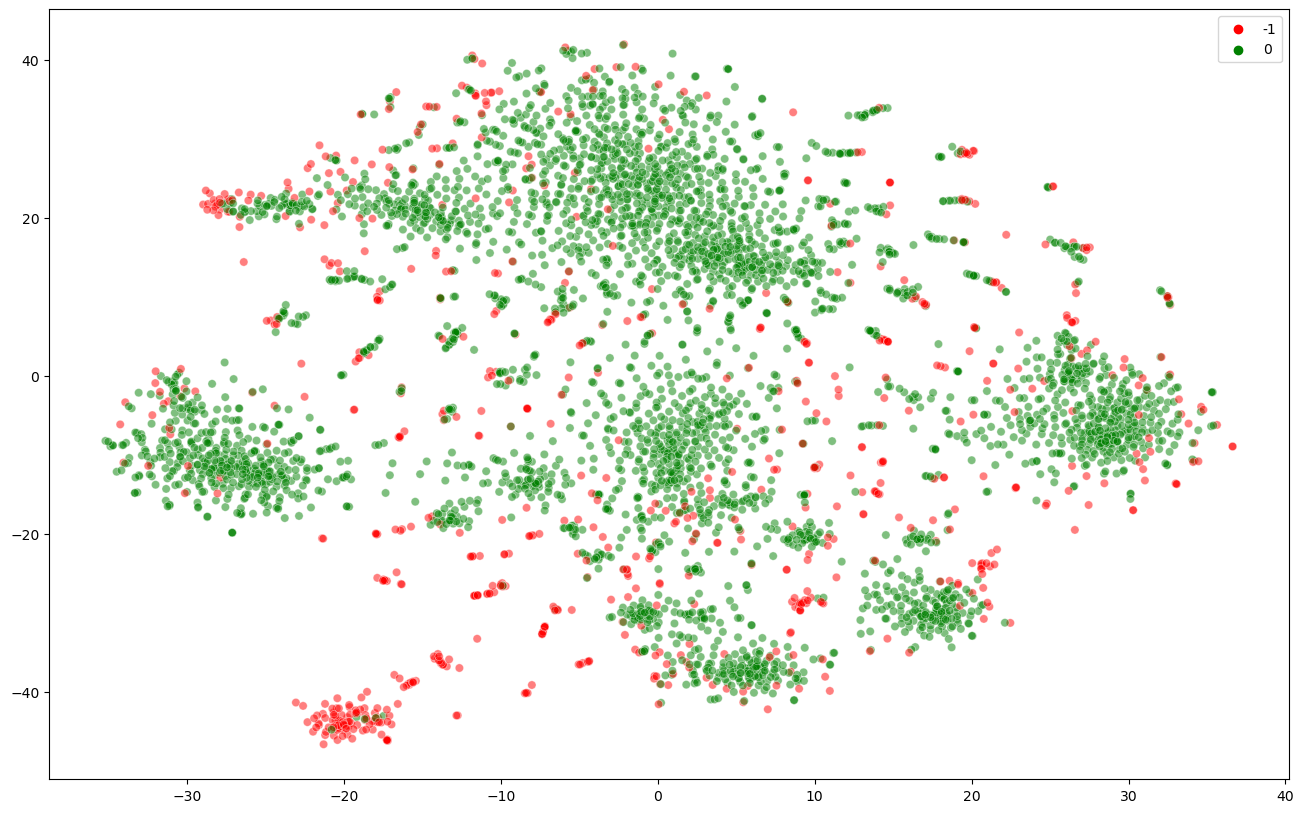

In [7]:
X_minlen, X_maxlen = process_traces(2)
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(X_maxlen)
dbscan = DBSCAN(eps=0.8, min_samples=100)
clustering = dbscan.fit_predict(X_maxlen)
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)

/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_60065/2823114244.py:7: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)


<AxesSubplot: >

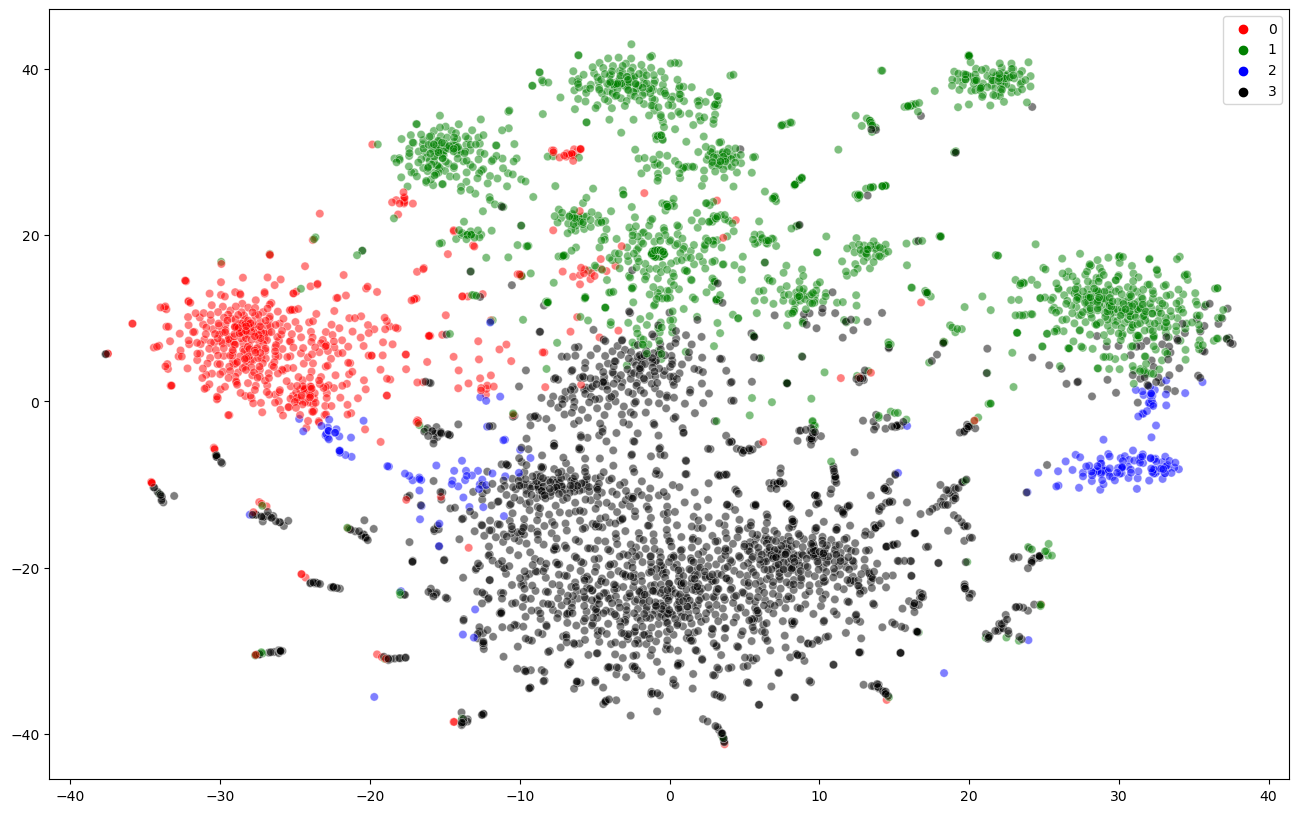

In [17]:
X_maxlen, X_minlen = process_traces(2)

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(X_minlen)
kmeans = KMeans(n_clusters=4)
clustering = kmeans.fit_predict(X_minlen)
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)

/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_17276/3668737686.py:8: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)


<AxesSubplot: >

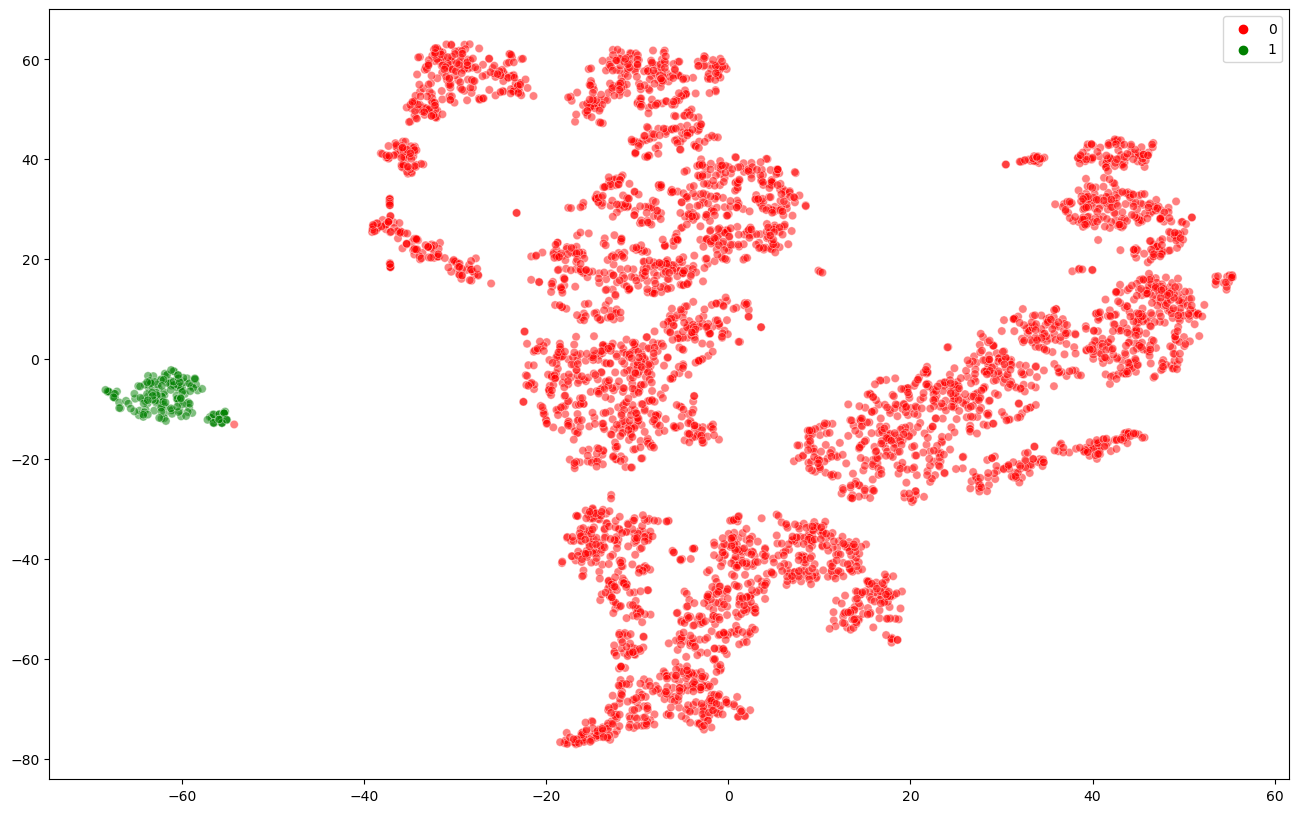

In [33]:
X = traces[88]

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(X)
kmeans = KMeans(n_clusters=2)
clustering = kmeans.fit_predict(X)
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)

/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_17276/1689985268.py:8: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)


<AxesSubplot: >

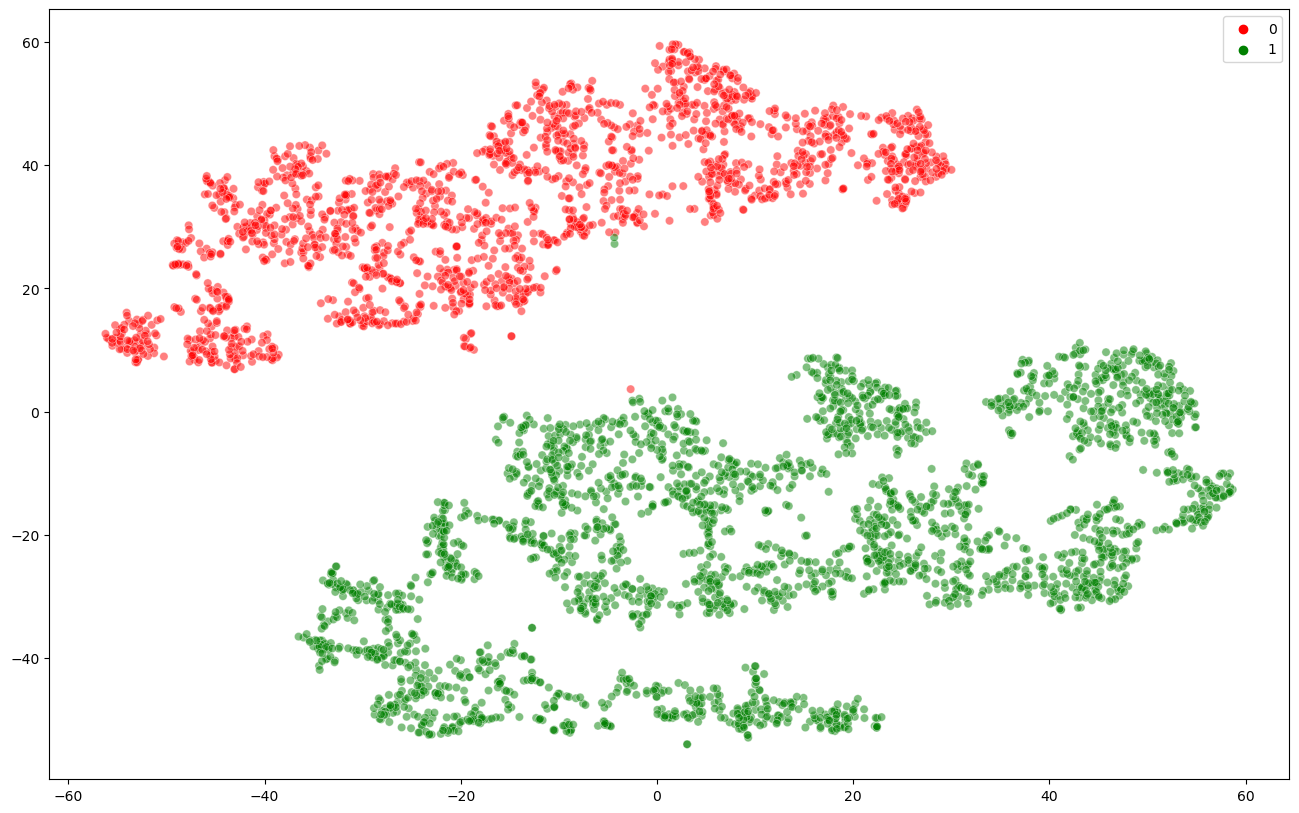

In [36]:
X = traces[99]

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(X)
kmeans = KMeans(n_clusters=2)
clustering = kmeans.fit_predict(X)
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)

/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: >

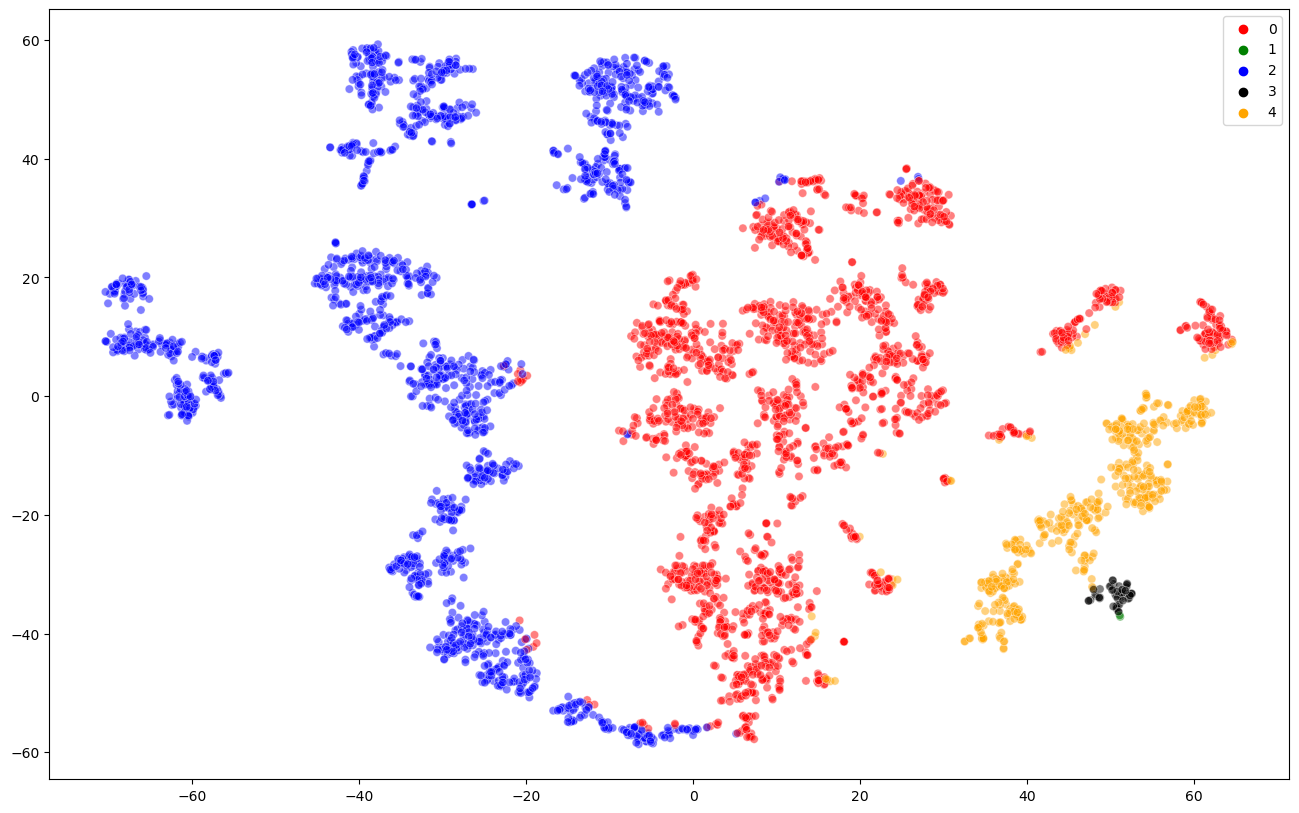

In [26]:
X = traces[95]

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(X)
kmeans = KMeans(n_clusters=5)
clustering = kmeans.fit_predict(X)
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)

/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_17276/3691310719.py:8: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)


<AxesSubplot: >

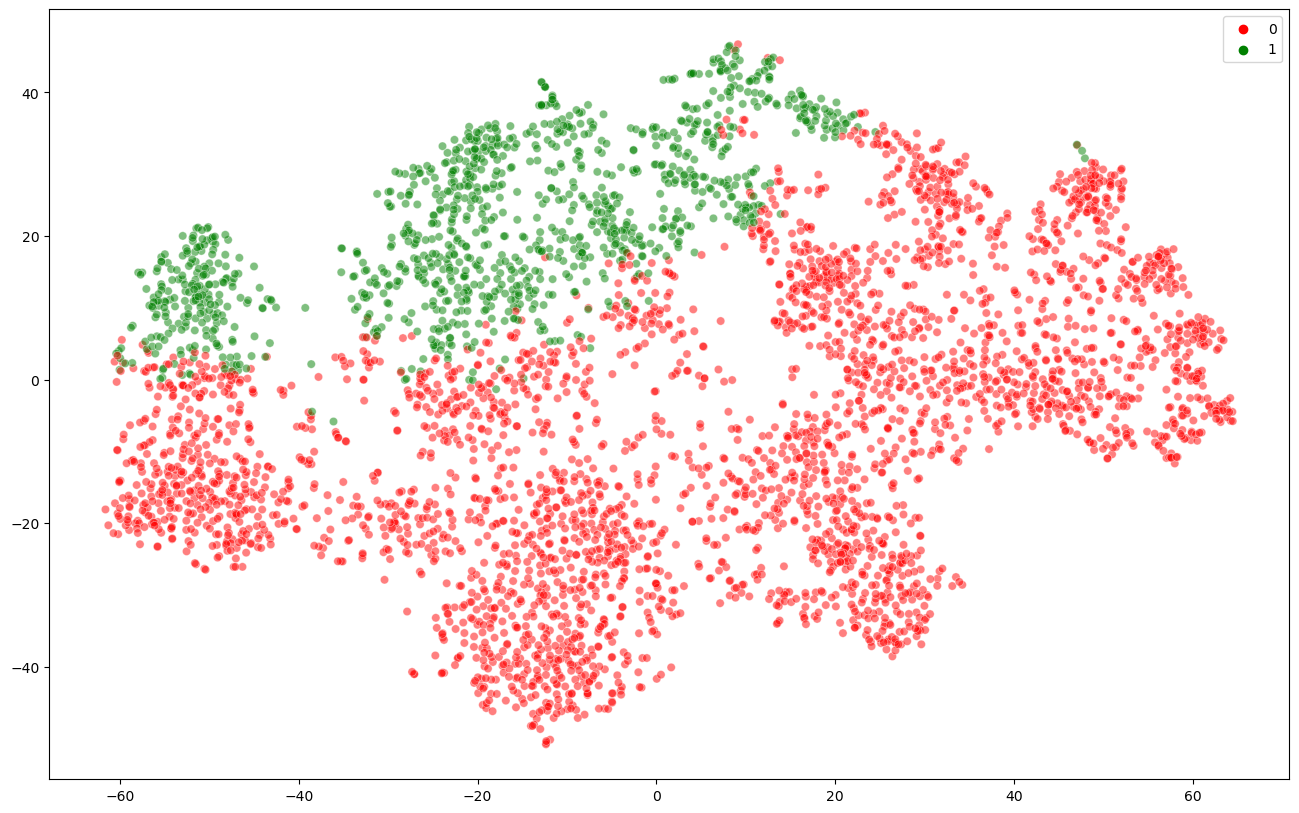

In [27]:
X = traces[65]

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(X)
kmeans = KMeans(n_clusters=2)
clustering = kmeans.fit_predict(X)
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)

/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michaelwrana/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_27138/2125520782.py:8: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)


<AxesSubplot: >

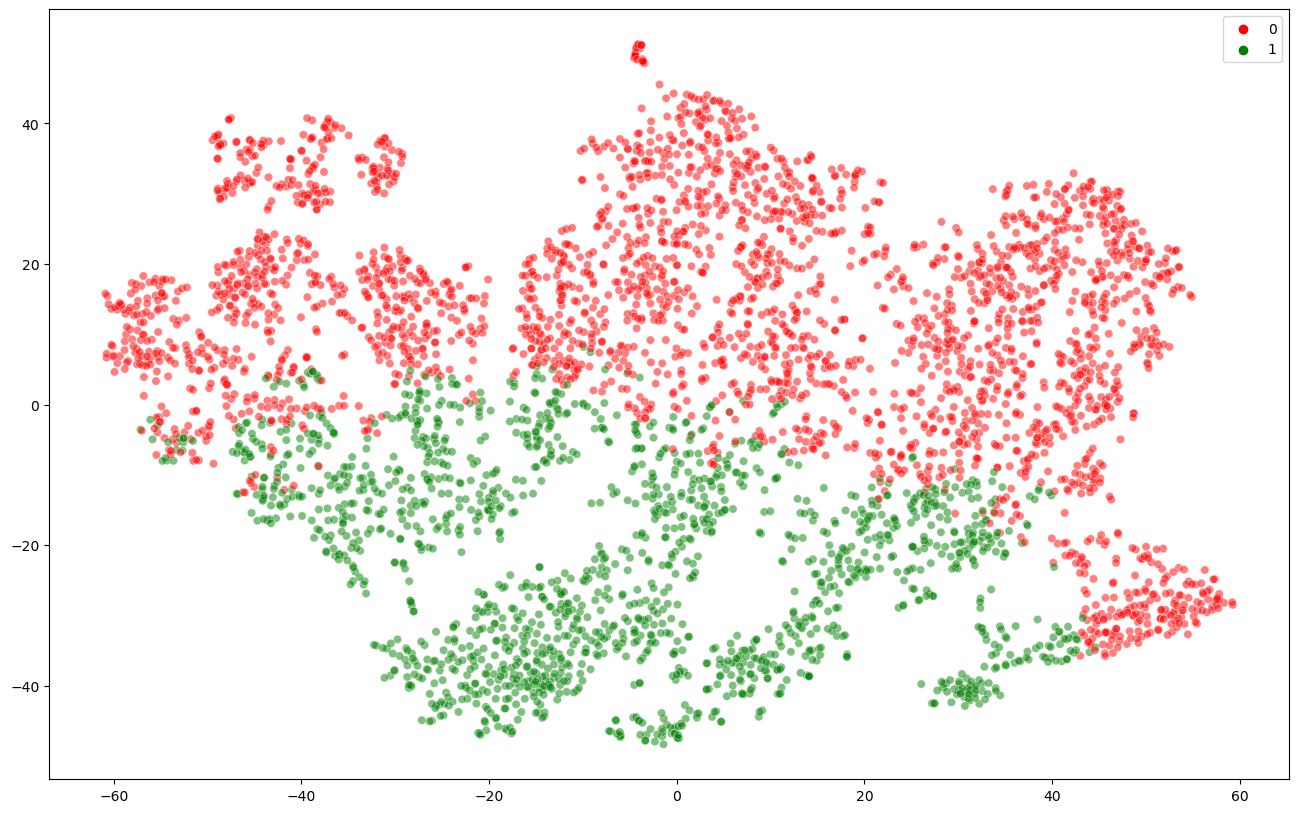

In [39]:
X = traces[16]

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(X)
kmeans = KMeans(n_clusters=2)
clustering = kmeans.fit_predict(X)
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0],y=tsne_results[:,1],hue=clustering,palette=["red", "green", "blue", "black", "orange"], alpha=0.5)